Using device: cpu


100%|██████████| 45/45 [22:54<00:00, 30.54s/it]


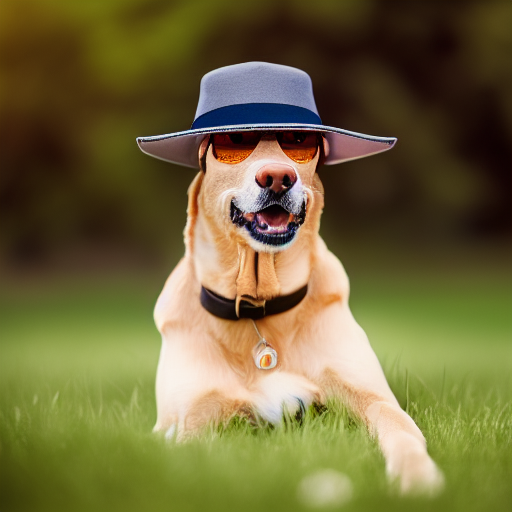

In [ ]:
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch
from torchvision import transforms

# ---------------------------------------
# Configurazione dispositivo
# ---------------------------------------

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

DEVICE = "cuda"
ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"

print(f"Using device: {DEVICE}")

# ---------------------------------------
# Caricamento tokenizer e modello
# ---------------------------------------
tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

# ---------------------------------------
# TEXT TO IMAGE / INPAINTING
# ---------------------------------------
prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
uncond_prompt = ""
do_cfg = True
cfg_scale = 8
strength = 0.6

# ---------------------------------------
# Percorsi opzionali per inpainting
# ---------------------------------------
image_path = "../images/dog.jpg"       # Immagine di partenza (es. con un buco)
mask_path = "../images/mask.png"       # Maschera binaria (bianco = zona da ricostruire)

input_image = None
mask_tensor = None

if Path(image_path).exists():
    input_image_pil = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])
    input_tensor = transform(input_image_pil).unsqueeze(0).to(DEVICE)
    input_image = input_tensor

    if Path(mask_path).exists():
        mask_pil = Image.open(mask_path).convert("L")
        mask_tensor = transform(mask_pil).unsqueeze(0).to(DEVICE)
        mask_tensor = (mask_tensor > 0.5).float()  # binarizzazione

# ---------------------------------------
# SAMPLING
# ---------------------------------------
sampler = "ddpm"
num_inference_steps = 50
seed = 42

# ---------------------------------------
# Generazione (usa inpainting se input_image + mask presenti)
# ---------------------------------------
if input_image is not None and mask_tensor is not None:
    print("Eseguo inpainting...")
    output = pipeline.sample(
        prompt=prompt,
        model=models,
        tokenizer=tokenizer,
        init_image=input_image,
        mask=mask_tensor,
        num_steps=num_inference_steps,
        guidance_scale=cfg_scale
    )
else:
    print("Eseguo text-to-image standard...")
    output = pipeline.generate(
        prompt=prompt,
        uncond_prompt=uncond_prompt,
        input_image=input_image,
        strength=strength,
        do_cfg=do_cfg,
        cfg_scale=cfg_scale,
        sampler_name=sampler,
        n_inference_steps=num_inference_steps,
        seed=seed,
        models=models,
        device=DEVICE,
        idle_device="cpu",
        tokenizer=tokenizer,
    )

# Converte il tensore in immagine PIL
if output.dim() == 4 and output.shape[0] == 1:
    output = output.squeeze(0)

output_image = output.detach().cpu().permute(1, 2, 0).numpy()
output_image = (output_image * 255).clip(0, 255).astype(np.uint8)
output_type = "inpainting" if input_image is not None and mask_tensor is not None else "text2img"

img = Image.fromarray(output_image)
img.show()
img.save(f"output_{output_type}.png")

Using device: cuda


100%|██████████| 50/50 [00:03<00:00, 14.81it/s]


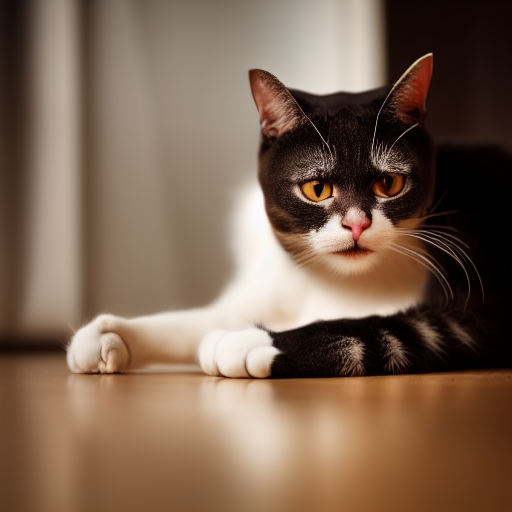

In [2]:
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

DEVICE = "cpu"
ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "A cat stretching on the floor, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

input_image = None
# Comment to disable image to image
image_path = "../images/dog.jpg"
# input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.9

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)
